# AE 예제

In [2]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from tqdm.notebook import tqdm

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
device

'cpu'

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

In [4]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [15]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() # original loss function
            # loss를 MSE로 해보자
            # loss = nn.MSELoss(reduction='sum')(x, x_hat) # https://discuss.pytorch.org/t/bool-value-of-tensor-with-more-than-one-value-is-ambiguous/48049/2
            loss.backward()
            opt.step()
    return autoencoder

In [16]:
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device) # GPU

data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=128,
        shuffle=True)

In [17]:
# 학습시키기
autoencoder = train(autoencoder, data)

  0%|          | 0/20 [00:00<?, ?it/s]

In [9]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        # z = z.to('cpu').detach().numpy() # original
        z = z.detach().cpu().numpy() # https://byeongjo-kim.tistory.com/32
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

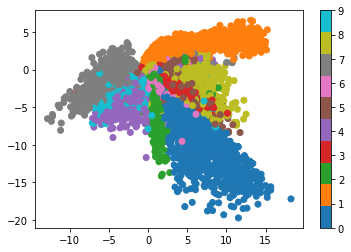

In [10]:
plot_latent(autoencoder, data) # loss = nn.MSELoss(reduction='mean')(x, x_hat) 

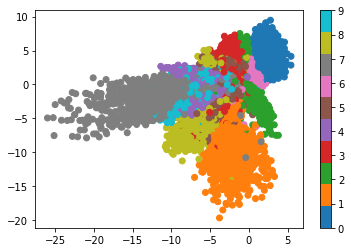

In [18]:
plot_latent(autoencoder, data) # loss = nn.MSELoss(reduction='sum')(x, x_hat) 

In [20]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)): # *r1은 쉽다!. 이건 r1 = (-10, 5) 를 -10, 5로 쓰겠다는 이야기임. 그냥 바깥의 괄호를 없애는 역할이라고 보면됨
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

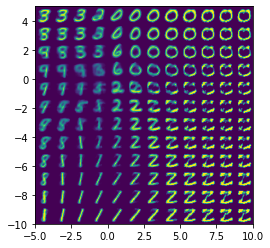

In [21]:
plot_reconstructed(autoencoder)

# VAE 예제

In [26]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        # cuda()
        # self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        # self.N.scale = self.N.scale.cuda()
        # cpu()
        self.N.loc = self.N.loc.cpu() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cpu()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [27]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [30]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [31]:
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae = train(vae, data)

  0%|          | 0/20 [00:00<?, ?it/s]

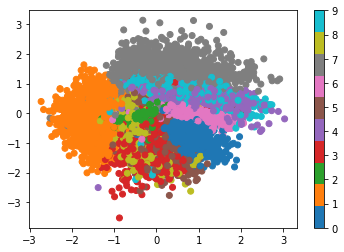

In [32]:
plot_latent(vae, data)

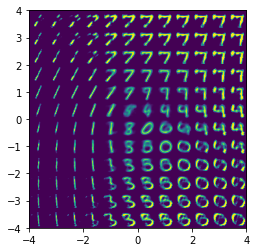

In [54]:
plot_reconstructed(vae, r0=(-4, 4), r1=(-4, 4))

In [71]:
x, y = data.__iter__().next() # hack to grab a batch
x_1 = x[y == 1][1].to(device) # find a 1
x_2 = x[y == 0][1].to(device) # find a 0

In [72]:
def interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

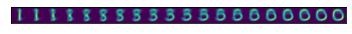

In [73]:
interpolate(vae, x_1, x_2, n=20)

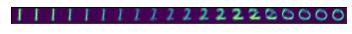

In [74]:
interpolate(autoencoder, x_1, x_2, n=20)

In [75]:
from PIL import Image

def interpolate_gif(autoencoder, filename, x_1, x_2, n=100):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)

    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])

    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()*255

    images_list = [Image.fromarray(img.reshape(28, 28)).resize((256, 256)) for img in interpolate_list]
    images_list = images_list + images_list[::-1] # loop back beginning

    images_list[0].save(
        f'{filename}.gif',
        save_all=True,
        append_images=images_list[1:],
        loop=1)

In [65]:
interpolate_gif(vae, "vae", x_1, x_2)

In [66]:
interpolate_gif(autoencoder, "ae", x_1, x_2)

In [56]:
x, y = data.__iter__().next() # hack to grab a batch
x_1 = x[y == 1][1].to(device) # find a 1
x_2 = x[y == 0][1].to(device) # find a 0

In [53]:
# asterisks 사용법 in python
arr = ['sunday', 'monday', 'tuesday', 'wednesday']
  
# without using asterisk
print(' '.join(map(str,arr))) 
  
# using asterisk
print (*arr)

sunday monday tuesday wednesday
sunday monday tuesday wednesday


In [48]:
# using asterisk
def addition(*args):
  return sum(args)
  
print(addition(5, 10, 20, 6))

TypeError: addition() takes 1 positional argument but 4 were given